In [1]:
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex
from src.metat import metat_load
from scipy.stats import gmean
from matplotlib.patches import FancyArrowPatch 
import math 
import itertools

%load_ext autoreload
%autoreload 2

palette = {'top':'lightblue', 'middle':'steelblue', 'bottom':'gray'}
abundance_symbol = '$A_{M}$'
activity_symbol = '$A_{T}$'
log_10 = lambda text : 'log$_{10}$(' + text + ')'


In [2]:
def _get_fraction_reads_in_top_genes(df, n:int=20, min_genes:int=50):
    df = df.sort_values('read_count', ascending=False)
    n_genes = df[df.read_count > 0].gene_id.nunique()
    total = df.read_count.sum()
    if (total == 0) | (n_genes < min_genes):
        return 0
    return df.iloc[:n].read_count.sum() / total

def get_fraction_reads_in_top_genes(metat_df:pd.DataFrame, n:int=20, min_genes:int=50):
    metat_df = metat_df[~metat_df.gene_id.isin(['mp_18.1_2492', 'mp_18.1_2493'])].copy()
    df = metat_df.groupby(['genome_id', 'sample_id']).apply(lambda df : _get_fraction_reads_in_top_genes(df, n=n, min_genes=min_genes), include_groups=False).reset_index(name='fraction_reads_in_top_genes')
    metat_df = metat_df.merge(df, on=['genome_id', 'sample_id'], how='left')
    return metat_df.copy()

In [3]:
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)
coverm_df = coverm_df[coverm_df.reactor == 'n'].copy()
coverm_df['sample_id'] = coverm_df.sample_id.str.replace('n_', '')

metat_df = metat_load(data_dir='../data/metat/', group_genomes=False)
metat_df = metat_df[metat_df.reactor == 'n'].copy()
metat_df['sample_id'] = metat_df.sample_id.str.replace('n_', '')
metat_df = metat_df[~metat_df.gene_id.isin(['mp_18.1_2492', 'mp_18.1_2493'])].copy()
metat_df = get_fraction_reads_in_top_genes(metat_df)
metat_df = metat_group_genomes(metat_df)

In [4]:
genome_metadata_df = pd.read_csv('./data/genome_metadata.csv')
drep_df = pd.read_csv('../data/ggkbase/drep/data_tables/Cdb.csv')
drep_df['genome'] = drep_df.genome.str.replace('.contigs.fa', '')
drep_df['genome_id'] = drep_df.genome.map(genome_metadata_df.set_index('ggkbase_id').genome_id)
# genome_metadata_df[]
# drep_df.groupby('secondary_cluster').genome.unique().to_dict()
drep_df[~drep_df.genome_id.isnull()]
drep_df = drep_df.sort_values(['secondary_cluster', 'genome_id'], ascending=True)
drep_df['genome_id'] = drep_df.genome_id.ffill()
drep_df['black_borg_host'] = drep_df.genome.str.contains('Black')
genome_metadata_df['black_borg_host'] = genome_metadata_df.genome_id.map(drep_df.groupby('genome_id').black_borg_host.sum() > 0)


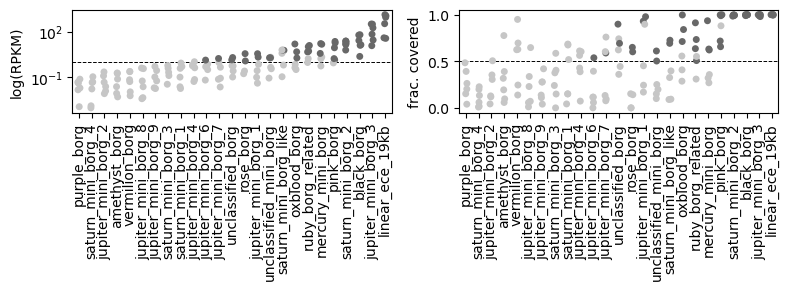

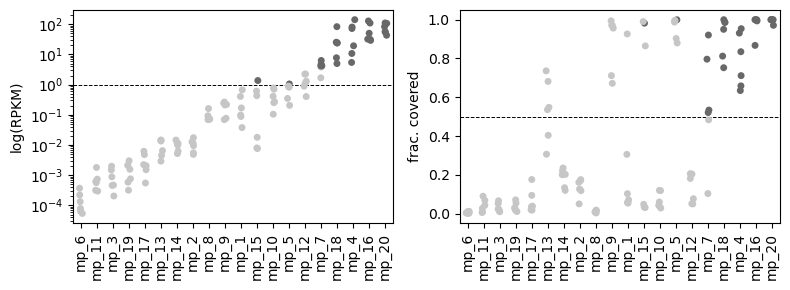

In [5]:
# Due to strain similarity, going to define some cutoffs. 
# Minimum RPKM of 0.1 and minimum genome coverage of 30.

min_rpkm = 1
min_fraction_covered_bases = 0.5

def plot_filter(figure_df:pd.DataFrame):
    figure_df['mean_rpkm'] = figure_df.genome_id.map(figure_df.groupby('genome_id').rpkm.mean())
    figure_df['meets_threshold'] = (figure_df.fraction_covered_bases > min_fraction_covered_bases) & (figure_df.rpkm > min_rpkm)
    figure_df = figure_df.sort_values('mean_rpkm')

    fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 3), ncols=2)
    sns.stripplot(figure_df, x='genome_id', y='rpkm', ax=ax_a, palette='Grays', hue='meets_threshold', legend=False)
    ax_a.set_xticks(ax_a.get_xticks(), ax_a.get_xticklabels(), rotation=90)
    ax_a.set_xlabel('')
    ax_a.set_ylabel('log(RPKM)')
    ax_a.set_yscale('log')
    ax_a.axhline(min_rpkm, ls='--', color='black', lw=0.7)

    sns.stripplot(figure_df, x='genome_id', y='fraction_covered_bases', palette='Grays', ax=ax_b, hue='meets_threshold', legend=False)
    ax_b.set_xticks(ax_b.get_xticks(), ax_b.get_xticklabels(), rotation=90)
    ax_b.set_ylabel('frac. covered')
    ax_b.set_xlabel('')
    ax_b.axhline(min_fraction_covered_bases, ls='--', color='black', lw=0.7)

    fig.tight_layout()
    plt.show()

    return figure_df[figure_df.meets_threshold].genome_id.unique().tolist()

ece_genome_ids = plot_filter(coverm_df[~is_mp(coverm_df)].copy())
mp_genome_ids = plot_filter(coverm_df[is_mp(coverm_df)].copy())

# mp_genome_ids = ['mp_13']  # Methanoperedens IDs sorted by abundance. 

In [6]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_white_to_blue = LinearSegmentedColormap.from_list('blues', ['white', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

In [7]:
mp_genome_ids

['mp_15', 'mp_5', 'mp_7', 'mp_18', 'mp_4', 'mp_16', 'mp_20']

In [8]:
def plot_abundance(figure_df:pd.DataFrame, title='', legend:bool=True, ax=None, genome_ids:list=None):

    figure_df = figure_df.sort_values(['sample_id', 'genome_id'], ascending=True)

    # figure_df = figure_df.copy()
    figure_df['year'] = [re.search(r'202\d', sample_id).group(0) for sample_id in figure_df.sample_id]
    figure_df = figure_df[figure_df.genome_id.isin(genome_ids)].copy()
    
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    genome_ids = sorted(figure_df.genome_id.unique())
    palettes = dict()
    palettes['2024'] = dict(zip(genome_ids, cmap_sample(cmap_grays, len(genome_ids))))
    palettes['2025'] = dict(zip(genome_ids, cmap_sample(cmap_blues, len(genome_ids))))
    # print(palettes)

    bottom = np.zeros(n_samples)
    for genome_id, df in figure_df.groupby('genome_id'):
        colors = [palettes[year].get(genome_id, 'red') for year in df.year]
        heights = df.set_index('sample_id').rpkm.to_dict() # Make this robust to when some samples aren't present. 
        heights = np.array([heights.get(sample_id, 0) for sample_id in sample_ids])
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=genome_id, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(len(sample_ids)), labels=sample_ids, rotation=90)

    if legend:
        handles = [Patch(edgecolor='black', linewidth=0.7, facecolor=palettes['2024'][genome_id]) for genome_id in genome_ids]
        ax.legend(handles, genome_ids)


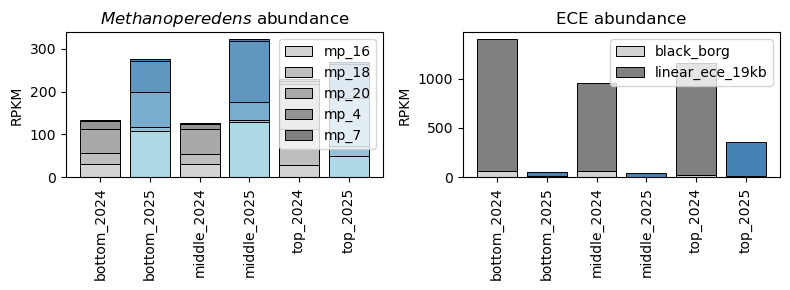

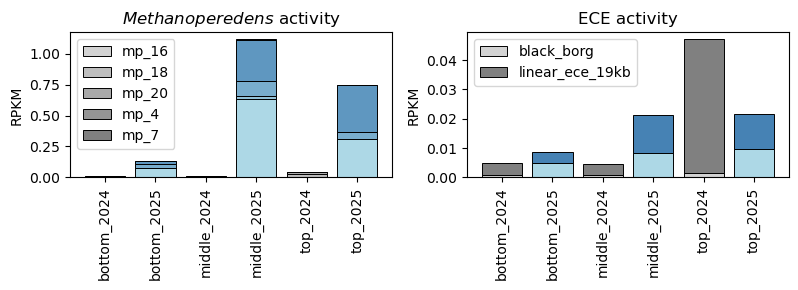

In [9]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 3), ncols=2)
plot_abundance(coverm_df, ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', genome_ids=mp_genome_ids[-5:])
plot_abundance(coverm_df, ax=ax_b, title='ECE abundance', genome_ids=['black_borg', 'linear_ece_19kb'])
fig.tight_layout()
plt.show()

fig, (ax_a, ax_b) = plt.subplots(figsize=(8, 3), ncols=2)
plot_abundance(metat_df, ax=ax_a, title=r'$\it{Methanoperedens}$ activity', genome_ids=mp_genome_ids[-5:])
plot_abundance(metat_df, ax=ax_b, title='ECE activity', genome_ids=['black_borg', 'linear_ece_19kb'])
fig.tight_layout()
plt.show()

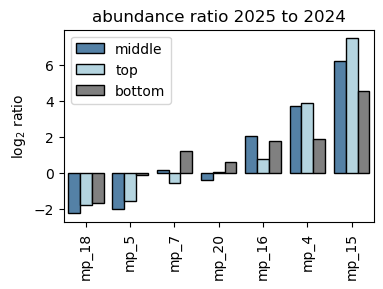

In [10]:
def plot_abundance_fold_change(coverm_df:pd.DataFrame=coverm_df, genome_ids=mp_genome_ids, title=''):

    fig, ax = plt.subplots(figsize=(4, 2.5))
    
    figure_df = coverm_df[coverm_df.genome_id.isin(genome_ids)].copy()
    figure_df = figure_df.pivot(index=['location', 'genome_id'], columns='year', values='rpkm')
    figure_df = figure_df.reset_index()
    figure_df['log2_fold_change'] = np.log2(figure_df['2025'] / figure_df['2024'])
    figure_df = figure_df.sort_values('log2_fold_change')

    sns.barplot(figure_df, y='log2_fold_change', hue='location', palette=palette, x='genome_id', edgecolor='black')
    ax.set_ylabel('log$_2$ ratio')
    ax.set_xlabel('')
    ax.get_legend().set_title('')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_title(title)
    plt.show()

plot_abundance_fold_change(coverm_df, title='abundance ratio 2025 to 2024')
# plot_abundance_fold_change(metat_df, title='activity ratio 2025 to 2024')


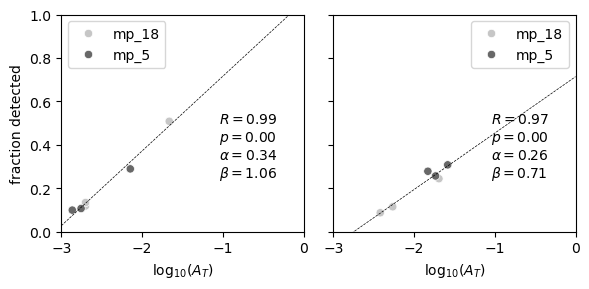

In [11]:


def plot_activity_versus_fraction_detected(metat_df:pd.DataFrame, genome_ids=mp_genome_ids, year='2024', ax=None):

    figure_df = metat_df[(metat_df.reactor == 'n') & (metat_df.year == year) & metat_df.genome_id.isin(genome_ids)].copy()
    figure_df['rpkm'] = np.log10(figure_df.rpkm)
    figure_df = figure_df[figure_df.rpkm > -3].copy()
    
    sns.scatterplot(figure_df, x='rpkm', y='fraction_detected', hue='genome_id', palette='Grays', ax=ax)
    ax.set_xlabel(log_10(activity_symbol))
    ax.set_ylabel('fraction detected')
    sns.move_legend(ax, loc='upper left')
    ax.set_xlim(xmin=-3, xmax=0)
    ax.set_ylim(ymin=0, ymax=1)

    m, b = np.polyfit(figure_df.rpkm, figure_df.fraction_detected, deg=1)
    x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[-1], 100)
    sns.lineplot(x=x, y=m * x + b , color='black', lw=0.5, ls='--', ax=ax)

    result = scipy.stats.pearsonr(figure_df.rpkm, figure_df.fraction_detected)
    text = f'$R=${result.statistic:.2f}\n'
    text += f'$p=${result.pvalue:.2f}\n'
    text += fr'$\alpha=${m:.2f}' + '\n'
    text += fr'$\beta=${b:.2f}'
    ax.text(0.65, 0.25, text, transform=ax.transAxes)

fig, axes = plt.subplots(figsize=(6, 3), ncols=2, sharey=True) 
genome_ids = ['mp_18', 'mp_5']
# genome_ids += ['mp_16', 'mp_4', 'mp_20']
# genome_ids = ['mp_16']
plot_activity_versus_fraction_detected(metat_df, genome_ids=genome_ids, year='2024', ax=axes[0])
plot_activity_versus_fraction_detected(metat_df, genome_ids=genome_ids, year='2025', ax=axes[1])
fig.tight_layout()
plt.show()

# log10(y) = x, so y = 10^x... every increase in x corresponds to a 10-fold increase in y. 
# I think makes sense, as fraction of genome covered should be related to a Poisson distribution, which is a^k * e^-a

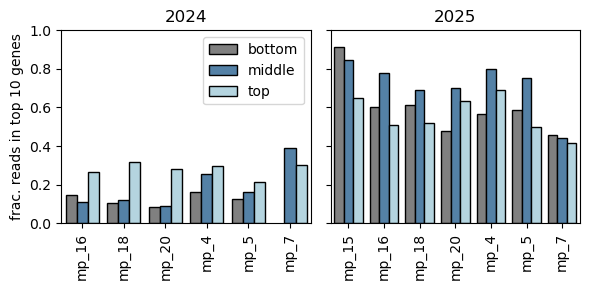

In [12]:
def plot_fraction_reads_in_top_genes(metat_df:pd.DataFrame=metat_df, genome_ids=mp_genome_ids, n:int=5, min_n_reads:int=100, fig_size=(6, 4)):

    metat_df = metat_load(data_dir='../data/metat/', group_genomes=False)
    metat_df = metat_df[(metat_df.reactor == 'n') & metat_df.genome_id.isin(genome_ids)].copy()
    metat_df['sample_id'] = metat_df.sample_id.str.replace('n_', '')
    metat_df = metat_df[~metat_df.gene_id.isin(['mp_18.1_2492', 'mp_18.1_2493'])].copy()
    metat_df = get_fraction_reads_in_top_genes(metat_df, n=n, min_genes=n)
    figure_df = metat_group_genomes(metat_df)
    figure_df = figure_df[figure_df.read_count > min_n_reads].copy()

    fig, axes = plt.subplots(figsize=fig_size, ncols=2, sharey=True)

    # figure_df = figure_df[figure_df.fraction_reads_in_top_genes > 0].copy()

    for year, ax in zip(['2024', '2025'], axes):
        sns.barplot(figure_df[figure_df.year == year], x='genome_id', y='fraction_reads_in_top_genes', hue='location', ax=ax, palette=palette, edgecolor='black', legend=(year == '2024'))
        if ax.get_legend() is not None:
            ax.get_legend().set_title('')
        ax.set_title(year)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_ylabel(f'frac. reads in top {n} genes')
    
    ax.set_ylim(ymin=0, ymax=1)

    fig.tight_layout()
    plt.show()

# plot_fraction_reads_in_top_genes(genome_ids=['black_borg', 'jupiter_mini_borg_3', 'saturn_mini_borg_2', 'linear_ece_19kb'])
plot_fraction_reads_in_top_genes(genome_ids=mp_genome_ids, n=10, fig_size=(6, 3))

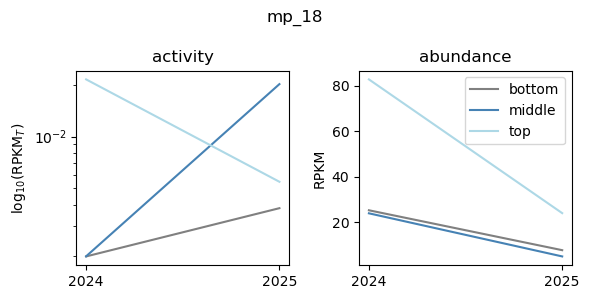

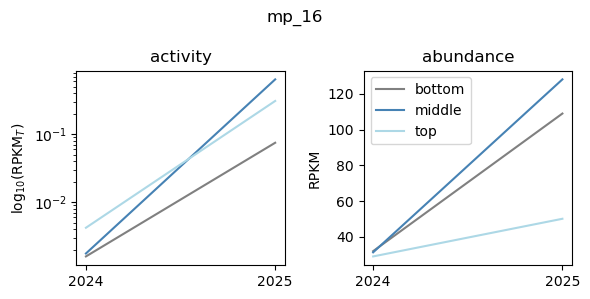

In [13]:


def plot_genome_changes(genome_id:str, metat_df:pd.DataFrame=metat_df, coverm_df:pd.DataFrame=coverm_df, normalize_activity:bool=True):

    coverm_df = coverm_df[coverm_df.genome_id == genome_id].copy().set_index('sample_id')
    metat_df = metat_df[metat_df.genome_id == genome_id].copy().set_index('sample_id')

    fig, axes = plt.subplots(figsize=(6, 3), ncols=2)

    figure_df = coverm_df[['year', 'reactor', 'location']].copy()
    figure_df['rpkm_metat'] = metat_df.rpkm
    figure_df['rpkm_coverm'] = coverm_df.rpkm
    figure_df['rpkm_ratio'] = figure_df.rpkm_metat / figure_df.rpkm_coverm
    figure_df['metat_coverage'] = metat_df.fraction_detected

    ax = axes[0]
    y_col = 'rpkm_ratio' if normalize_activity else 'rpkm_metat'
    for location, df in figure_df.groupby('location'):
        sns.lineplot(x=[0, 1], y=df.sort_values('year')[y_col].values, ax=ax, color=palette[location])
    ax.set_xticks([0, 1], ['2024', '2025'])
    ax.set_ylabel('log$_{10}$(RPKM$_{T}/RPKM$_{A}$)' if normalize_activity else 'log$_{10}$(RPKM$_{T})$')
    ax.set_title('normalized activity' if normalize_activity else 'activity')
    ax.set_yscale('log')

    ax = axes[1]
    for location, df in figure_df.groupby('location'):
        sns.lineplot(x=[0, 1], y=df.sort_values('year').rpkm_coverm.values, ax=ax, label=location, color=palette[location])
    ax.set_xticks([0, 1], ['2024', '2025'])
    ax.set_ylabel('RPKM')
    ax.set_title('abundance')

    # ax = axes[2]
    # for location, df in figure_df.groupby('location'):
    #     sns.lineplot(x=[0, 1], y=df.sort_values('year').metat_coverage.values, label=location, ax=ax, color=palette[location])
    # ax.set_xticks([0, 1], ['2024', '2025'])
    # ax.set_ylabel('coverage')
    # ax.set_title('genome coverage')

    fig.suptitle(genome_id)
    fig.tight_layout()
    plt.show()

# sns.stripplot(figure_df, x='year', y='rpkm_ratio')
plot_genome_changes('mp_18', normalize_activity=False)
plot_genome_changes('mp_16', normalize_activity=False)
# plot_genome_changes('mp_16')
# plot_genome_changes('mp_4')


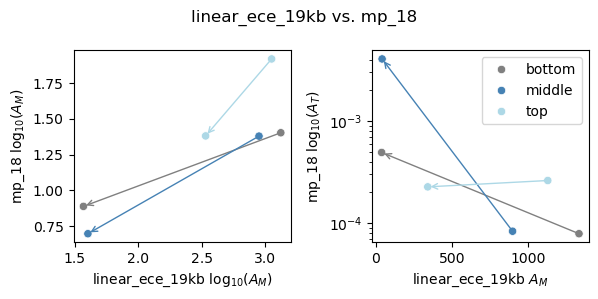

In [14]:
# host_genome_id, ece_genome_id = 'mp_18', 'black_borg'
# host_genome_id, ece_genome_id = 'mp_18', 'linear_ece_19kb'


def plot_host_ece_changes(host_genome_id, ece_genome_id, metat_df:pd.DataFrame=metat_df, coverm_df:pd.DataFrame=coverm_df, log_scale:bool=True):

    coverm_df = coverm_df.copy().set_index('sample_id')
    metat_df = metat_df.copy().set_index('sample_id')

    figure_df= coverm_df[['year', 'reactor', 'location']][~coverm_df.index.duplicated(keep='first')].copy()
    figure_df['rpkm_coverm_host'] = coverm_df[(coverm_df.genome_id == host_genome_id)].rpkm
    figure_df['rpkm_coverm_ece'] = coverm_df[(coverm_df.genome_id == ece_genome_id)].rpkm
    figure_df['log10_rpkm_coverm_host'] = np.log10(figure_df.rpkm_coverm_host)
    figure_df['log10_rpkm_coverm_ece'] = np.log10(figure_df.rpkm_coverm_ece)
    figure_df['rpkm_metat_host'] = metat_df[(metat_df.genome_id == host_genome_id)].rpkm
    figure_df['rpkm_metat_ece'] = metat_df[(metat_df.genome_id == ece_genome_id)].rpkm
    figure_df['rpkm_ratio_host'] = figure_df.rpkm_metat_host / figure_df.rpkm_coverm_host

    palette = {'top':'lightblue', 'middle':'steelblue', 'bottom':'gray'}
    fig, axes = plt.subplots(figsize=(6, 3), ncols=2)
    ax = axes[0]

    if log_scale:
        y_col, x_col = f'log10_rpkm_coverm_host', 'log10_rpkm_coverm_ece'
        y_label, x_label = f'{host_genome_id} ' + log_10(abundance_symbol), f'{ece_genome_id} ' + log_10(abundance_symbol)
    else:
        y_col, x_col = f'rpkm_coverm_host', 'rpkm_coverm_ece'
        y_label, x_label = f'{host_genome_id} {abundance_symbol}', f'{ece_genome_id} {abundance_symbol}'
    sns.scatterplot(figure_df, x=x_col, y=y_col, hue='location', palette=palette, ax=ax, legend=False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    for location, df in figure_df.groupby('location'):
        df = df.sort_values('year')
        xy = list(zip(df[x_col].values, df[y_col].values))
        arrow = FancyArrowPatch(xy[0], xy[1], arrowstyle='->', linewidth=1, mutation_scale=10, color=palette[location])
        ax.add_patch(arrow)

    ax = axes[1]
    sns.scatterplot(figure_df, x='rpkm_coverm_ece', y='rpkm_ratio_host', hue='location', palette=palette, ax=ax, legend=True)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_ylabel(f'{host_genome_id} ' + log_10(activity_symbol))
    ax.set_xlabel(f'{ece_genome_id} {abundance_symbol}')
    ax.get_legend().set_title('')

    for location, df in figure_df.groupby('location'):
        df = df.sort_values('year')
        xy = list(zip(df.rpkm_coverm_ece.values, df.rpkm_ratio_host.values))
        arrow = FancyArrowPatch(xy[0], xy[1], arrowstyle='->', linewidth=1, mutation_scale=10, color=palette[location])
        ax.add_patch(arrow)

    fig.suptitle(f'{ece_genome_id} vs. {host_genome_id}')
    fig.tight_layout()

# plot_host_ece_changes('mp_18', 'black_borg')
plot_host_ece_changes('mp_18', 'linear_ece_19kb')


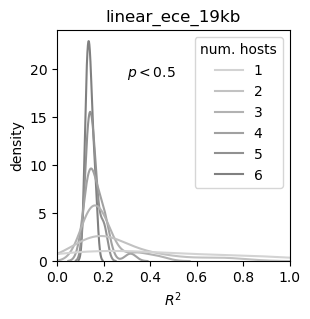

mp_18 R=0.88 p=0.021
mp_7+mp_18 R=0.84 p=0.036
mp_5+mp_18 R=0.68 p=0.140
mp_5+mp_7+mp_18 R=0.66 p=0.155
mp_18+mp_20 R=0.60 p=0.203


In [15]:
def get_activity_correlation_info(host_genome_ids:list, ece_genome_id, metat_df:pd.DataFrame=metat_df, log_scale:bool=True):  
    host_genome_id = '+'.join(host_genome_ids) # Make a composite host genome ID with the possible hosts. 
    info = {'host_genome_id':host_genome_id, 'ece_genome_id':ece_genome_id, 'n_hosts':len(host_genome_ids)}

    df = metat_df[metat_df.genome_id.isin(host_genome_ids + [ece_genome_id])].copy()
    df['genome_id'] = np.where(df.genome_id.isin(host_genome_ids), host_genome_id, df.genome_id)
    df = metat_group_genomes(df) # Group the values for the two host genomes.
    df = df.pivot(index='sample_id', values='rpkm', columns='genome_id')
    
    if log_scale:
        df[ece_genome_id] = np.log10(df[ece_genome_id])
        df[host_genome_id] = np.log10(df[host_genome_id])

    # Automatically computes two-sided, so both positive and negative correlations have the same p-value.
    r = scipy.stats.pearsonr(df[host_genome_id], df[ece_genome_id])
    info['pearson_statistic'] = r.statistic
    info['pearson_p_value'] = r.pvalue
    return info 

# Goal is to try out different combinations of host genome IDs and see which are best correlated with the ECE. 

ece_genome_id = 'jupiter_mini_borg_3'
# ece_genome_id = 'saturn_mini_borg_2'
ece_genome_id = 'linear_ece_19kb'
# ece_genome_id = 'black_borg'
# ece_genome_id = 'pink_borg'
host_genome_ids = mp_genome_ids

figure_df = list()

# How many combinations are there?
n_hosts = np.arange(1, len(host_genome_ids))
# print('Num. combinations with 4 hosts:', math.comb(len(n_hosts), 4))
for n in n_hosts:
    for host_genome_ids_ in itertools.combinations(host_genome_ids, n):
        figure_df.append(get_activity_correlation_info(list(host_genome_ids_), ece_genome_id))
figure_df = pd.DataFrame(figure_df)
# Removes the sign, so won't throw out negative correlations. 
figure_df['pearson_statistic_squared'] = figure_df.pearson_statistic ** 2

min_p_value = 0.5
fig, ax = plt.subplots(figsize=(3, 3))
figure_df = figure_df[figure_df.pearson_p_value < min_p_value].copy()

# sns.scatterplot(figure_df, x='n_hosts', y='pearson_statistic', hue='n_hosts')
sns.kdeplot(figure_df, x='pearson_statistic_squared', hue='n_hosts', common_norm=False, palette=cmap_grays)
ax.get_legend().set_title('num. hosts')
ax.set_ylabel('density')
ax.set_xlabel('$R^2$')
ax.set_xlim(xmin=0, xmax=1)
ax.set_title(ece_genome_id)
ax.text(0.3, 0.8, f'$p < {min_p_value}$', transform=ax.transAxes)
plt.show()

# If sample size is the same (which it is), I think the R^2 value is always going to increase as the
# p-value increases. 
# TODO: Should look into the actual relationship between R^2 and the p-value. 

figure_df = figure_df.sort_values(['pearson_p_value', 'pearson_statistic_squared'], ascending=[True, False])
for row in figure_df.iloc[:5].itertuples():
    print(row.host_genome_id, f'R={row.pearson_statistic:.2f}', f'p={row.pearson_p_value:.3f}')



In [16]:
figure_df

,host_genome_id,ece_genome_id,n_hosts,pearson_statistic,pearson_p_value,pearson_statistic_squared
3,mp_18,linear_ece_19kb,1,0.880327,0.020625,0.774976
18,mp_7+mp_18,linear_ece_19kb,2,0.841118,0.035860,0.707480
14,mp_5+mp_18,linear_ece_19kb,2,0.676038,0.140427,0.457027
43,mp_5+mp_7+mp_18,linear_ece_19kb,3,0.658006,0.155440,0.432972
24,mp_18+mp_20,linear_ece_19kb,2,0.604969,0.203252,0.365988
...,...,...,...,...,...,...
124,mp_15+mp_7+mp_18+mp_4+mp_16+mp_20,linear_ece_19kb,6,0.354261,0.490839,0.125501
38,mp_15+mp_18+mp_16,linear_ece_19kb,3,0.352402,0.493279,0.124187
59,mp_18+mp_4+mp_16,linear_ece_19kb,3,0.350907,0.495244,0.123136
74,mp_15+mp_7+mp_18+mp_16,linear_ece_19kb,4,0.350179,0.496201,0.122626


In [27]:
def plot_correlation(x, y, ax=None, color='gray'):
    m, b = np.polyfit(x, y, deg=1)
    sns.scatterplot(x=x, y=y, color=color)
    x_ = np.linspace(ax.get_xlim()[0], ax.get_xlim()[-1], 100)
    sns.lineplot(x=x_, y=m * x_ + b , color='black', lw=0.5, ls='--', ax=ax)

    result = scipy.stats.pearsonr(x, y)
    text = f'$R=${result.statistic:.2f}\n'
    text += f'$p=${result.pvalue:.2f}\n'
    text += fr'$\alpha=${m:.2f}' + '\n'
    text += fr'$\beta=${b:.2f}'
    return text

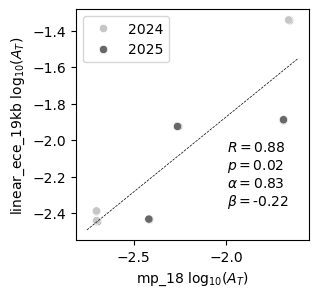

In [32]:
def plot_activity_correlation(host_genome_ids:list, ece_genome_id, metat_df:pd.DataFrame=metat_df, log_scale:bool=True, host_genome_id:str=None):
    
    fig, ax = plt.subplots(figsize=(3, 3))

    host_genome_id = '+'.join(host_genome_ids) if (host_genome_id is None) else host_genome_id
    figure_df = metat_df[metat_df.genome_id.isin(host_genome_ids + [ece_genome_id])].copy()
    figure_df['genome_id'] = np.where(figure_df.genome_id.isin(host_genome_ids), host_genome_id, figure_df.genome_id)
    figure_df = metat_group_genomes(figure_df) # Group the values for the two host genomes.
    figure_df = figure_df.pivot(index=['sample_id', 'year'], values='rpkm', columns='genome_id').reset_index()
    
    if log_scale:
        figure_df[ece_genome_id] = np.log10(figure_df[ece_genome_id])
        figure_df[host_genome_id] = np.log10(figure_df[host_genome_id])
        x_label, y_label = f'{host_genome_id} ' + log_10(activity_symbol), f'{ece_genome_id} ' + log_10(activity_symbol)
    else:
        x_label, y_label = f'{host_genome_id} activity', f'{ece_genome_id} activity'

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    text = plot_correlation(figure_df[host_genome_id], figure_df[ece_genome_id], ax=ax)
    sns.scatterplot(figure_df, x=host_genome_id, y=ece_genome_id, hue='year', palette='Grays')
    ax.get_legend().set_title('')

    ax.text(0.65, 0.15, text, transform=ax.transAxes)
    plt.show()

# plot_activity_correlation(mp_genome_ids, 'black_borg', log_scale=True, host_genome_id='mp_*')
plot_activity_correlation(['mp_18'], 'linear_ece_19kb', log_scale=True, )
# plot_activity_correlation('mp_16', 'black_borg', log_scale=False)


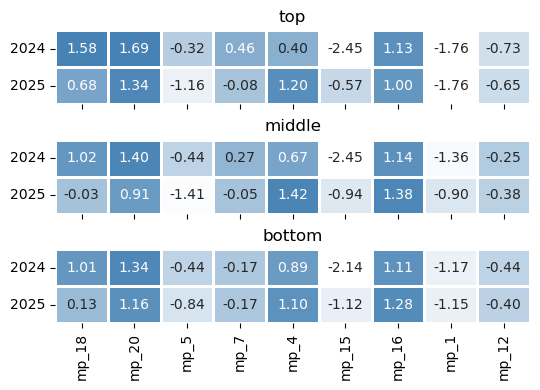

In [19]:

reformat_sample_id = lambda row : f'{row.year}_{row.location}'

def get_clr_normalization(df):
    df = df.copy()
    df['geometric_mean'] = df.sample_id.map(df.groupby('sample_id').apply(lambda df_ : scipy.stats.gmean(df_.rpkm), include_groups=False))
    df['rpkm_clr_normalized'] = np.log10(df.rpkm) - np.log10(df.geometric_mean)
    return df


def plot_composition(figure_df:pd.DataFrame, genome_ids=mp_genome_ids):

    figure_df = figure_df[figure_df.genome_id.isin(genome_ids)].copy()
    figure_df['location'] = pd.Categorical(figure_df.location, categories=['top', 'middle', 'bottom'], ordered=True)
    figure_df = figure_df.sort_values('location')

    figure_df = get_clr_normalization(figure_df)

    fig, axes = plt.subplots(figsize=(5.5, 4), nrows=3, sharex=True)
    for (location, df), ax in zip(figure_df.groupby('location', observed=True), axes):
        df = df.pivot(index='year', columns='genome_id', values='rpkm_clr_normalized')
        df = df[genome_ids] # Make sure the column order is correct. 
        # NOTE: None indexing adds a dimension. 
        sns.heatmap(df, cmap=cmap_white_to_blue, annot=True, cbar=False, lw=1, fmt='.2f', vmin=-1.5, vmax=1.5, ax=ax)
        # sns.heatmap((figure_df - figure_df.mean(axis=0).values[None, :]) / figure_df.std(axis=0).values[None, :], lw=1, cmap=cmap_white_to_blue, annot=figure_df, cbar=False, fmt='.2f', ax=ax)
        # sns.heatmap((df - df.mean(axis=1).values[:, None]) / df.std(axis=1).values[:, None], lw=1, cmap=cmap_white_to_blue, annot=df, cbar=False, fmt='.2f', ax=ax, vmax=1.5, vmin=-1.5)
        ax.set_ylabel('')
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_title(location)

    fig.tight_layout()
    plt.show()

mp_genome_ids_ordered = ['mp_18', 'mp_20', 'mp_5', 'mp_7', 'mp_4', 'mp_15', 'mp_16', 'mp_1', 'mp_12']
plot_composition(coverm_df, genome_ids=mp_genome_ids_ordered)
# plot_composition(metat_agg_df)

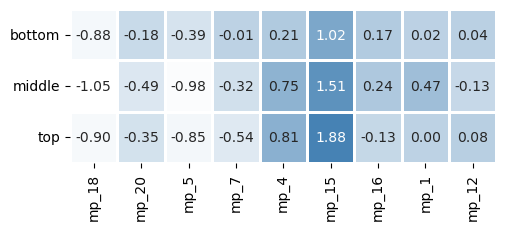

In [20]:
def plot_composition_change(figure_df:pd.DataFrame, genome_ids=mp_genome_ids, title=''):

    figure_df = figure_df[(figure_df.reactor == 'n') & figure_df.genome_id.isin(genome_ids)].copy()
    figure_df = get_clr_normalization(figure_df)
    figure_df = figure_df.sort_values('location')

    figure_df_2024 = figure_df[figure_df.year == '2024'].copy().pivot(index='location', columns='genome_id', values='rpkm_clr_normalized')
    figure_df_2025 = figure_df[figure_df.year == '2025'].copy().pivot(index='location', columns='genome_id', values='rpkm_clr_normalized')
    figure_df = figure_df_2025 - figure_df_2024


    fig, ax = plt.subplots(figsize=(5.5, 2))
    figure_df = figure_df
    figure_df = figure_df[genome_ids]
    sns.heatmap(figure_df, cmap=cmap_white_to_blue, annot=True, cbar=False, lw=1, fmt='.2f')
    # sns.heatmap((figure_df - figure_df.mean(axis=0).values[None, :]) / figure_df.std(axis=0).values[None, :], cmap=cmap_white_to_blue, annot=figure_df, cbar=False, fmt='.2f', ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_title(title)
    plt.show()


mp_genome_ids_ordered = ['mp_18', 'mp_20', 'mp_5', 'mp_7', 'mp_4', 'mp_15', 'mp_16', 'mp_1', 'mp_12']
plot_composition_change(coverm_df, genome_ids=mp_genome_ids_ordered)

NameError: name 'metat_agg_df' is not defined

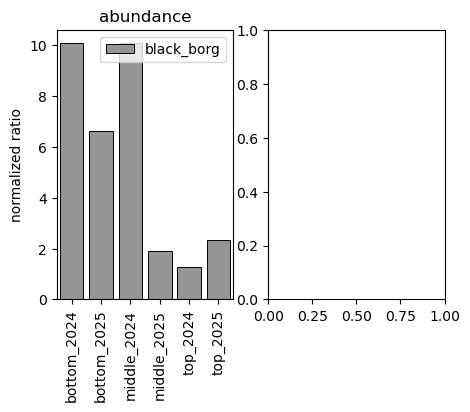

In [21]:
# What if we assume that mp_13 is the only host? What happens to the ratio?


# host_genome_ids = ['mp_18']
# ece_genome_ids = ['black_borg','saturn_mini_borg_2', 'jupiter_mini_borg_3' ]


def plot_ratios(figure_df, ax=None, ece_genome_ids=['linear_ece_19kb'], host_genome_ids=None, legend:bool=True, title:str='', palette:str=None):
    host_read_counts = coverm_df[coverm_df.genome_id.isin(host_genome_ids)].groupby('sample_id').read_count.sum().to_dict()
    host_genome_size = figure_df[figure_df.genome_id.isin(host_genome_ids)].drop_duplicates('genome_id').genome_size.sum()

    figure_df = figure_df[figure_df.genome_id.isin(ece_genome_ids)].copy()
    figure_df['host_read_count'] = figure_df.sample_id.map(host_read_counts)
    figure_df['read_count_ratio'] = (figure_df.read_count / figure_df.genome_size) / (figure_df.host_read_count / host_genome_size)
    figure_df = figure_df.sort_values(['reactor', 'location', 'year'])

    sns.barplot(figure_df, x='sample_id', y='read_count_ratio', lw=0.7, edgecolor='black', palette=palette, hue='genome_id', ax=ax, legend=legend)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('normalized ratio')
    # ax.set_ylabel('read count ratio')
    ax.set_xlabel('')
    if legend:
        ax.get_legend().set_title('')
    ax.set_title(title)

kwargs = dict()
# kwargs['host_genome_ids'] = ['mp_18', 'mp_5',]
kwargs['host_genome_ids'] = ['mp_18'] 
kwargs['ece_genome_ids'] = ['black_borg']

fig, (ax_a, ax_b) = plt.subplots(figsize=(5, 3.5), ncols=2)
plot_ratios(coverm_df[coverm_df.reactor == 'n'].copy(), ax=ax_a, title='abundance', palette='Grays', **kwargs)
plot_ratios(metat_agg_df[metat_agg_df.reactor == 'n'].copy(), ax=ax_b, legend=False, title='activity', palette='Blues', **kwargs)
# ax_b.set_ylim(ymax=5)
# fig.suptitle(f'candidate hosts: {', '.join(host_genome_ids)}')
fig.tight_layout()
plt.show()

In [ ]:
print(mp_genome_ids)

['mp_15', 'mp_5', 'mp_7', 'mp_18', 'mp_4', 'mp_16', 'mp_20']


In [ ]:
# figure_df = metat_df.copy()
# figure_df = figure_df[figure_df.genome_id.isin(mp_genome_ids)].copy()
# figure_df = figure_df.groupby(['genome_id', 'sample_id']).agg({'read_count':'sum', 'genome_size':'sum', 'library_size':'first'}).reset_index()
# figure_df['rpkm'] = figure_df.read_count / (figure_df.genome_size / 1e3) / (figure_df.library_size / 1e6)
# figure_df = get_clr_normalization(figure_df)
# figure_df = figure_df[figure_df.sample_id.str.startswith('n_')].copy()
# figure_df['sample_id'] = figure_df.sample_id.str.replace('_metat', '')
# figure_df['sample_id'] = [f'{sample_id.split('_')[-1]}_{sample_id.split('_')[1]}' for sample_id in figure_df.sample_id]
# figure_df = figure_df.sort_values('sample_id')

# fig, ax = plt.subplots(figsize=(4, 4))
# figure_df = figure_df.pivot(index='sample_id', columns='genome_id', values='rpkm_clr_normalized')
# sns.heatmap(figure_df, cmap='Grays', annot=True, cbar=False)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('control')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(3, 2))
# figure_df =  bbduk_df[(bbduk_df.reactor == 'n') & (bbduk_df.index.str.contains('metat'))].copy() # Bioreactor samples only.
# figure_df = figure_df.reset_index(drop=False) 
# figure_df['sample_id'] = figure_df.sample_id.str.replace('_metat', '')
# figure_df['sample_id'] = figure_df.location
# figure_df = figure_df.sort_values(['location', 'year'])
# sns.barplot(figure_df, y='library_size', hue='year', palette='Grays', x='sample_id', color='lightgray', edgecolor='black', lw=0.7) #, hue='library_size', palette='Grays', legend=False)
# ax.set_xlabel('')
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
# ax.set_ylabel('library size')
# ax.set_title('metaT library sizes')
# ax.get_legend().set_title('')
# sns.move_legend(ax, loc='lower right')
# plt.show()

In [ ]:
# genome_id = 'mp_18'
# # genome_id = 'black_borg'
# # genome_id = 'linear_ece_19kb'
# normalize = False

# genome_size = coverm_df[coverm_df.genome_id == genome_id].genome_size.iloc[0]
# print(f'Num bases in {genome_id}:', genome_size)

# fig, ax = plt.subplots(figsize=(2.5, 4))

# metat_mask = (metat_df.genome_id == genome_id) & (metat_df.reactor == 'n')
# coverm_mask = (coverm_df.genome_id == genome_id) & (coverm_df.reactor == 'n')

# n_samples = 6
# figure_df = pd.DataFrame(index=np.arange(n_samples))
# figure_df['sample_id'] = coverm_df[coverm_mask].sample_id.unique()
# figure_df = figure_df.set_index('sample_id')
# figure_df['read_count_metat'] = metat_df[metat_mask].groupby('sample_id').read_count.sum()
# figure_df['coverage_metat'] = metat_df[metat_mask].groupby('sample_id').detected.mean() * 100

# if normalize:
#     figure_df['read_count_metat'] = 1e6 * figure_df.read_count_metat /  metat_df.groupby('sample_id').library_size.first()

# # figure_df['read_count_coverm'] = coverm_df[coverm_mask].groupby('sample_id').read_count.first()
# figure_df['abundance'] = coverm_df[coverm_mask].groupby('sample_id').rpkm.first()
# # figure_df['coverage_coverm'] = coverm_df[coverm_mask].groupby('sample_id').fraction_covered_bases.first() * 100

# if normalize:
#     figure_df = figure_df.rename(columns={'read_count_metat':'num. metaT reads (CPM)', 'coverage_metat':'frac. detected genes', 'abundance':'abundance (RPKM)'})
# else:
#     figure_df = figure_df.rename(columns={'read_count_metat':'num. metaT reads', 'coverage_metat':'frac. detected genes', 'abundance':'abundance (RPKM)'})
# sns.heatmap((figure_df / figure_df.sum(axis=0)), cbar=False, cmap='Grays', annot=figure_df.astype(int), fmt='d', lw=2)
# # sns.heatmap((figure_df - figure_df.mean(axis=0)) / figure_df.std(axis=0), cbar=False, cmap='Grays', annot=figure_df.astype(int), fmt='d')
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title(genome_id)
# plt.show()

# # Need a better way to communicate this data. Possibly look at abundance and transcription patterns separately
